In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy import stats
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

In [2]:
# function for calculating pdf

def conditional_densities(data,formula_ps_no_con,formula_ps_con, use_confounders=True):
    
    formula = formula_ps_con if use_confounders else formula_ps_no_con
        
    model = sm.formula.ols(formula, data=data).fit()
    density = stats.norm( 
        loc=model.fittedvalues,
        scale=model.resid.std(),
    )  
    densities = density.pdf(data["nSES"])
    densities = pd.Series(densities, index=model.fittedvalues.index)
    return densities


## data

In [3]:
mesa_std = pd.read_csv('../data_processed/MESA/mesa_std.csv', index_col=False)
mesa_std = mesa_std.dropna()

analysis_feature = ['cvd_10y_HF', 'cvd_10y_noHF',
                    'nSES','nFavFood','nPhysFac', 'nRS', 
                    'FamIncome', 'nutrition', 'PhysAct', 'currentSmoker', 'alc',
                    'age', 'gender', 'Diabetes', 'hdl', 'totchol', 'sbp',
                   'site', 'race']

mesa_std = mesa_std[analysis_feature]

mesa_bla_std = mesa_std[mesa_std['race'] == 1]


In [4]:
jhs_std = pd.read_csv('../data_processed/JHS/jhs_std.csv', index_col=False)
jhs_std = jhs_std.dropna()

analysis_feature = ['cvd_10y_HF', 'cvd_10y_noHF',
                    'nSES','nFavFood','nPhysFac', 'nRS', 
                    'FamIncome', 'nutrition', 'PhysAct', 'currentSmoker', 'alc',
                    'age','gender', 'Diabetes', 'hdl', 'totchol', 'sbp']

jhs_std = jhs_std[analysis_feature]

In [ ]:
# check nSES distribution

# jhs_std['nSES'].plot.kde()

# plt.title('Density Plot for nSES')
# plt.xlabel('nSES Values')
# plt.ylabel('Density')

# plt.show()

## Generalized IPW for single estimate

In [12]:
# define model 

data = jhs_std

formula_ps_no = "nSES ~ 1"
formula_ps = "nSES ~ 1 + nFavFood + nPhysFac + nRS + \
                C(FamIncome) + C(nutrition) + C(PhysAct) + C(currentSmoker) + C(alc) + \
                sbp + Diabetes + hdl + totchol + age"

In [13]:
# Step 1: estimate propensity density

denominator = conditional_densities(data, formula_ps_no,formula_ps, use_confounders=True)
numerator = conditional_densities(data, formula_ps_no,formula_ps, use_confounders=False)
generalized_ipw = numerator / denominator

In [14]:
# Step 2: Weighted Logistic regression 

formula_outcome = 'cvd_10y_noHF ~ 1 + nSES'

model = smf.logit(formula=formula_outcome, data=data, weights=generalized_ipw).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.247414
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           cvd_10y_noHF   No. Observations:                 3531
Model:                          Logit   Df Residuals:                     3529
Method:                           MLE   Df Model:                            1
Date:                Wed, 17 Apr 2024   Pseudo R-squ.:                 0.01261
Time:                        18:31:19   Log-Likelihood:                -873.62
converged:                       True   LL-Null:                       -884.77
Covariance Type:            nonrobust   LLR p-value:                 2.314e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.6426      0.069    -38.236      0.000      -2.778      -2.507
nSES           0.3469      0.

/Users/cxt/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
/Users/cxt/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


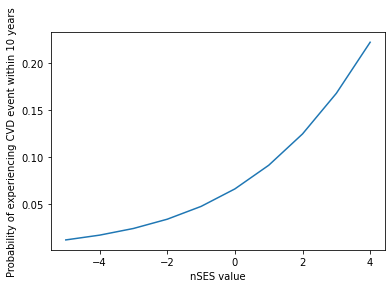

In [15]:
# visualize the predictions

dosage = list(range(-5,5))  # mesa: [-3.028026, 2.017261]; jhs: [-4.394192, 1.513734]
dosage = pd.DataFrame(
    data={"nSES": dosage},
    index=dosage,
)
response = model.predict(dosage)  # returns the probabilities of the dependent variable being equal to 1
ax = response.plot(
    kind="line",
    xlabel="nSES value",
    ylabel="Probability of experiencing CVD event within 10 years"
)


### check assumption

In [17]:
# misspecification of the propensity score model?
model = sm.formula.ols(formula_ps, data=mesa_std).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   nSES   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     254.2
Date:                Wed, 17 Apr 2024   Prob (F-statistic):               0.00
Time:                        19:25:39   Log-Likelihood:                -5164.6
No. Observations:                4619   AIC:                         1.037e+04
Df Residuals:                    4600   BIC:                         1.049e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   1.0846      0.092     11.756      0.000       0.904       1.265
C(FamIncome)[T.2.0]        -0.0669      0.046     -1.462      0.144      -0.157       0.023
C(FamIncome)[T.3.0]        -0.3141      0.041     -7.621      0.000      -0.395      -0.233
C(FamIncome)[T.4.0]        -0.8152      0.045    -17.933      0.000      -0.904      -0.726
C(nutrition)[T.1.0]        -0.0501      0.023     -2.178      0.029      -0.095      -0.005
C(nutrition)[T.2.0]         0.0716      0.186      0.384      0.701      -0.294       0.437
C(PhysAct)[T.1.0]          -0.0657      0.036     -1.832      0.067      -0.136       0.005
C(PhysAct)[T.2.0]          -0.1401      0.029     -4.899      0.000      -0.196      -0.084
C(currentSmoker)[T.1.0]    -0.0243      0.024     -1.028      0.304      -0.071       0.022
C(currentSmoker)[T.2.0]     0.0790      0.035      2.280      0.023       0.011       0.147
C(alc)[T.1.0]              -0.0897      0.025     -3.574      0.000      -0.139      -0.040
nFavFood                    0.3048      0.015     21.013      0.000       0.276       0.333
nPhysFac                   -0.6453      0.014    -44.930      0.000      -0.673      -0.617
nRS                         0.0911      0.011      8.160      0.000       0.069       0.113
sbp                         0.0372      0.012      3.030      0.002       0.013       0.061
Diabetes                    0.1012      0.037      2.709      0.007       0.028       0.175
hdl                        -0.0493      0.011     -4.312      0.000      -0.072      -0.027
totchol                    -0.0075      0.011     -0.660      0.509      -0.030       0.015
age                        -0.0095      0.001     -7.774      0.000      -0.012      -0.007
==============================================================================
Omnibus:                      338.229   Durbin-Watson:                   1.695
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1481.096
Skew:                          -0.218   Prob(JB):                         0.00
Kurtosis:                       5.740   Cond. No.                     1.07e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# adding spline in step2?


In [ ]:
# check balance??

# love plot displays standardized mean differences, but only works for binary treatment


In [ ]:
# check logistic regression assumption 

import pygam
from pygam import LogisticGAM, s

X = data['nSES']  # Predictor variables
y = data['Y_10y']  # Response variable

# Fit a GAM with a spline for each predictor variable
gam = LogisticGAM(s(0)).fit(X, y)

# Plot the partial dependence for each predictor to inspect linearity
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    plt.figure()
    plt.plot(XX[:, i], pdep)
    plt.plot(XX[:, i], confi, c='r', ls='--')
    plt.title(f'Partial Dependence')
    plt.show()

## roughly linear, assumption holds

## bootstrap for CI

In [6]:
def generate_formula(X_vars, M_vars,additional_vars, data):
    
    # Define different settings based on the dataset
    if data == "mesa":
        settings = [
            additional_vars + ['race', 'site'],
            additional_vars + ['race'],
            additional_vars + ['site'],
            additional_vars
        ]
    elif data == "mesa_bla":
        settings = [
            additional_vars + ['site'],
            additional_vars
        ]
    elif data == "jhs":
        settings = [additional_vars]  # No 'race' or 'site'
    else:
        settings = [additional_vars]  # Default setting, can be modified as needed
    
    formula_combinations = []

    # Generate combinations
    for setting in settings:
        
        Z = set(setting)  # Adjust Z based on the current setting
        
        for i in range(len(X_vars)):
        
            # Rotate X variables so a different one is in the first position
            rotated_X_vars = X_vars[i:] + X_vars[:i]
            
            X = rotated_X_vars[0]

            # Create the three formulas based on the current rotation
            formula_ps_no_con = f"{rotated_X_vars[0]} ~ 1"
            formula_ps_con = f"{rotated_X_vars[0]} ~ 1 + {' + '.join(rotated_X_vars[1:])} + " + \
                             " + ".join([f"C({m})" for m in M_vars]) + " + " + \
                             " + ".join(Z)
            formula_outcome = f'cvd_10y_noHF ~ 1 + {rotated_X_vars[0]}'   ###### noHF Y

            # Add the set of formulas to the list
            formula_combinations.append({
                'X': [X],
                'Z': list(Z),
                'formula_ps_no_con': formula_ps_no_con,
                'formula_ps_con': formula_ps_con,
                'formula_outcome': formula_outcome
            })
            
    return formula_combinations

In [7]:
def case_when(Z):
    if 'race' in Z and 'site' in Z:
        return 'race_site'
    elif 'race' in Z:
        return 'race'
    elif 'site' in Z:
        return 'site'
    else:
        return None  # Or any default value

In [8]:
# generate combination

# Define the variables
X_vars = ['nSES', 'nFavFood', 'nPhysFac', 'nRS']
M_vars = ['FamIncome', 'nutrition', 'PhysAct', 'currentSmoker', 'alc']
additional_vars = ['age', 'sbp', 'hdl', 'totchol', 'Diabetes']

# define the data
named_df_list = [('mesa_std', mesa_std)]
data_option = "mesa" 

# generate combo
formula_combinations = generate_formula(X_vars, M_vars,additional_vars, data_option)

In [ ]:
report_df = pd.DataFrame(columns=['Data','X','other','mean_coef', 'ci_lower','ci_upper' ])
iteration = 1000

for df_name, df in named_df_list:
    
    ### iterate on each formula combo ###
    for combo in formula_combinations:
        X = combo['X']
        Z = combo['Z']
        formula_ps_no_con = combo['formula_ps_no_con'] 
        formula_ps_con = combo['formula_ps_con'] 
        formula_outcome = combo['formula_outcome']
        
        coef_treatment = []
        
        for i in range(iteration):
            d_star = df.sample(n=df.shape[0], replace=True)

            # step 1
            denominator = conditional_densities(d_star, formula_ps_no_con,formula_ps_con, use_confounders=True)
            numerator = conditional_densities(d_star, formula_ps_no_con,formula_ps_con, use_confounders=False)
            generalized_ipw = numerator / denominator

            # step 2
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=UserWarning)
            model = smf.logit(formula=formula_outcome, data=d_star, weights=generalized_ipw).fit(disp=0)
            coef_treatment.append(model.params[1])

        # Calculate mean and 95% CI
        mean_coef = np.round(np.mean(coef_treatment), 5)
        ci_lower = np.round(np.percentile(coef_treatment, q=2.5), 5)
        ci_upper = np.round(np.percentile(coef_treatment, q=97.5), 5)

        new_df = pd.DataFrame(
                    {'Data': df_name,
                     'X': X,
                     'other': case_when(Z),
                     'mean_coef':mean_coef,
                     'ci_lower': ci_lower,
                     'ci_upper':ci_upper
                    })

        # append to the complete dataset
        report_df = pd.concat([report_df, new_df], ignore_index=True)
            
        # print(report_df)
        print("\n" + "="*50 + "\n")  


export_path = f"../results/G_IPW_noHF/{df_name}_G_ipw.csv"
report_df.to_csv(export_path)